In [1]:
import autograd.numpy as np
from autograd import grad, hessian
from autograd import elementwise_grad
from scipy.optimize import fmin_l_bfgs_b, fmin_bfgs, fmin_cg, fmin_ncg
import matplotlib.pyplot as plt
from scipy.linalg import cho_factor, cho_solve, cholesky
from autograd.scipy.linalg import solve_triangular
from sklearn.decomposition import FactorAnalysis, PCA
from sklearn.linear_model import LogisticRegression
from autograd.misc.optimizers import adam
import copy
import glob
import imageio
import skimage
from skimage import data, io, filters
from sklearn.model_selection import train_test_split



/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:24: UserWarning: The default multichannel argument (None) is deprecated.  Please specify either True or False explicitly.  multichannel will default to False starting with release 0.16.
  warn('The default multichannel argument (None) is deprecated.  Please '
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/anaconda2/lib/python2.7/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


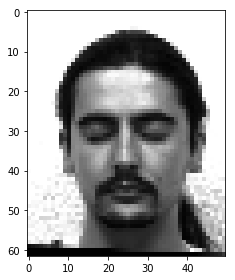

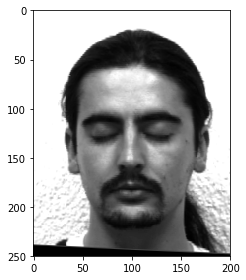

In [2]:
img_arr_rescaled = np.array([skimage.img_as_float(skimage.transform.rescale(imageio.imread(file),1.0 / 4.0)) for file in glob.glob('yale_reducted/*png')])
skimage.io.imshow(img_arr_rescaled[0])
skimage.io.show()

img_arr = np.array([skimage.img_as_float(imageio.imread(file)) for file in glob.glob('yale_reducted/*png')])
skimage.io.imshow(img_arr[0])
skimage.io.show()

In [3]:
def get_labels(filenames):
    labels = np.zeros(len(filenames))
    for i in range(len(filenames)):
        if any(s in filenames[i] for s in ('sad', 'wink', 'surprised', 'sleepy', 'happy')):
            labels[i] = 1
    return labels



In [4]:
img_arr_train = np.array([skimage.img_as_float(imageio.imread(file)) for file in glob.glob('yale_train/*png')])
img_arr_test = np.array([skimage.img_as_float(imageio.imread(file)) for file in glob.glob('yale_test/*png')])
X_train = np.reshape(img_arr_train, (img_arr_train.shape[0], img_arr_train.shape[1]*img_arr_train.shape[2]))
X_test = np.reshape(img_arr_test, (img_arr_test.shape[0], img_arr_test.shape[1]*img_arr_test.shape[2]))
y_train = get_labels(glob.glob('yale_train/*png'))
y_test = get_labels(glob.glob('yale_test/*png'))
clf_orig = LogisticRegression().fit(X_train, y_train)
test_acc_orig = clf_orig.score(X_test, y_test)
print test_acc_orig


/anaconda2/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


0.7


In [19]:
latent_dim = 2
transformer = PCA(latent_dim)
x_train_transformed_pca = transformer.fit_transform(X_train)
x_test_transformed_pca = transformer.transform(X_test)
clf_pca = LogisticRegression().fit(x_train_transformed_pca, y_train)
test_acc_pca = clf_pca.score(x_test_transformed_pca, y_test)
print test_acc_pca


0.525


In [6]:
img_arr_train = np.array([skimage.img_as_float(skimage.transform.rescale(imageio.imread(file),1.0 / 4.0)) for file in glob.glob('yale_train/*png')])
img_arr_test = np.array([skimage.img_as_float(skimage.transform.rescale(imageio.imread(file),1.0 / 4.0)) for file in glob.glob('yale_test/*png')])
X_train = np.reshape(img_arr_train, (img_arr_train.shape[0], img_arr_train.shape[1]*img_arr_train.shape[2]))
X_test = np.reshape(img_arr_test, (img_arr_test.shape[0], img_arr_test.shape[1]*img_arr_test.shape[2]))
y_train = get_labels(glob.glob('yale_train/*png'))
y_test = get_labels(glob.glob('yale_test/*png'))

In [42]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def objective_logit (params, x, y, latent_dim, lambda_e, opt): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters(params, D, latent_dim, opt)
        
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    #print cov_x.shape
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    #print log_det_cov_x
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    unnorm_log_pdf_x = np.einsum("nd,dn->n", x - bias_x, temp1)
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 

    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    lambda_r = 1
    reg1 = lambda_r*np.sum(f**2)
    reg2 = lambda_r*np.sum(w**2)
    reg = reg1+reg2
    ll = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior + reg
    return ll

def objective_logit_fast(params, x, y, latent_dim, lambda_e, opt, reg_weight): #check the order of arguments!
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters_fast(params, D, latent_dim, opt)
    L = f.shape[1]
        
    icn = (1.0 / cov_noise).reshape((-1, 1))
    xn = (x - bias_x).T
    Ax = icn * xn
    Au = icn * f
    C = np.eye(L) + np.dot(f.T, Au)
    temp1 = np.dot(f.T, Ax)
    temp1 = np.linalg.solve(C, temp1)
    temp1 = np.dot(Au, temp1)
    temp1 = Ax - temp1
    sign, log_det_cov_x = np.linalg.slogdet(C)
    log_det_cov_x += np.sum(np.log(cov_noise))
    
    unnorm_log_pdf_x = np.einsum("dn,dn->n", xn, temp1)
    
    mean_z = np.dot(f.T, temp1).T
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    log_prior = 0 
    reg = reg_weight*np.sum((f/np.sqrt(D))**2) + reg_weight*np.sum(w**2)
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    obj = ll - lambda_e*np.sum(log_bern_pdf_y) - log_prior + reg
    return obj



def decode_parameters_fast(params, D, latent_dim, opt):
    size_f = D*latent_dim
    f =  params[:size_f]
    #f = f*np.array([0,1]) + np.array([1,0])
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt=="ppca"):
        var = params[size_f+D]
        cov_noise= np.ones(D)*np.log(1+np.exp(var))
        #cov_noise= np.diag(np.ones(D)*np.exp(var))
        w = params[size_f+D+1:]
    else:
        var = params[size_f+D:size_f+D*2]
        cov_noise = np.log(1+np.exp(var))
        w = params[size_f+D*2:]
    return f, bias_x, cov_noise, w

def decode_parameters(params, D, latent_dim, opt):
    size_f = D*latent_dim
    f =  params[:size_f]
    #f = f*np.array([0,1]) + np.array([1,0])
    f =  f.reshape(D, latent_dim)
    bias_x = params[size_f:size_f+D]
    if (opt=="ppca"):
        var = params[size_f+D]
        cov_noise= np.diag(np.ones(D)*np.log(1+np.exp(var)))
        #cov_noise= np.diag(np.ones(D)*np.exp(var))
        w = params[size_f+D+1:]
    else:
        var = params[size_f+D:size_f+D*2]
        cov_noise= np.diag(np.log(1+np.exp(var)))
        w = params[size_f+D*2:]
    return f, bias_x, cov_noise, w

def transform(f, bias, cov_noise, x):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp = np.linalg.solve(cov_x, (x - bias).T)
    mean_z = np.einsum("dl,dn->nl", f, temp)
    return mean_z

    
def compute_ll(f,bias,cov_noise, x):
    N = x.shape[0]
    D = x.shape[1]
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    sign, log_det_cov_x = np.linalg.slogdet(cov_x)
    temp1 = np.linalg.solve(cov_x, (x - bias).T)
    ll = N*D*np.log(2*np.pi)/2
    ll += log_det_cov_x*N/2
    ll += np.sum(np.einsum("nd,dn->n", x - bias, temp1))/2
    return -ll

def compute_ll_fast(params, x, latent_dim, opt):
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters_fast(params, D, latent_dim, opt)
    L = f.shape[1]
        
    icn = (1.0 / cov_noise).reshape((-1, 1))
    xn = (x - bias_x).T
    Ax = icn * xn
    Au = icn * f
    C = np.eye(L) + np.dot(f.T, Au)
    temp1 = np.dot(f.T, Ax)
    temp1 = np.linalg.solve(C, temp1)
    temp1 = np.dot(Au, temp1)
    temp1 = Ax - temp1
    sign, log_det_cov_x = np.linalg.slogdet(C)
    log_det_cov_x += np.sum(np.log(cov_noise))
    
    unnorm_log_pdf_x = np.einsum("dn,dn->n", xn, temp1)
    
    ll = N*D*np.log(2*np.pi)/2 + log_det_cov_x*0.5*N + np.sum(unnorm_log_pdf_x)*0.5 
    return -ll


def compute_pll_logit(f, bias_x, cov_noise, w, x, y):
    cov_x = np.einsum("dl,ml->dm",f,f) + cov_noise
    temp1 = np.linalg.solve(cov_x, (x - bias_x).T)
    
    mean_z = np.einsum("dl,dn->nl", f, temp1)
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    return np.sum(log_bern_pdf_y)

def compute_pll_logit_fast(params, x, y, latent_dim, opt):
    N = x.shape[0]
    D = x.shape[1]
    f, bias_x, cov_noise, w = decode_parameters_fast(params, D, latent_dim, opt)
    L = f.shape[1]
        
    icn = (1.0 / cov_noise).reshape((-1, 1))
    xn = (x - bias_x).T
    Ax = icn * xn
    Au = icn * f
    C = np.eye(L) + np.dot(f.T, Au)
    temp1 = np.dot(f.T, Ax)
    temp1 = np.linalg.solve(C, temp1)
    temp1 = np.dot(Au, temp1)
    temp1 = Ax - temp1
    
    mean_z = np.dot(f.T, temp1).T
    temp2 = np.einsum("l,nl->n", w[1:], mean_z) + w[0]
    log_bern_pdf_y = np.log(sigmoid(np.multiply((2*y-1),temp2)))
    return np.sum(log_bern_pdf_y)

In [43]:
latent_dim = 2
x_dim = X_train.shape[1]      
params_size = x_dim*latent_dim + x_dim + 1 + latent_dim + 1
init_params = np.random.rand(params_size)
opt = "ppca"
f, bias, cov_noise, w =  decode_parameters(init_params, x_dim, latent_dim, opt)
print "Initial parameters"
print "F:", f
print "slope", f[1]/f[0]
print "bias: ", bias
print "cov_noise matrix: ", cov_noise
print "bias for y:\n", w[0]
print "logistic regression weights:\n", w[1:]


Initial parameters
F: [[0.16243402 0.29961316]
 [0.79477258 0.12135826]
 [0.25027044 0.9289535 ]
 ...
 [0.93672469 0.77528505]
 [0.17747762 0.71780234]
 [0.51866408 0.9598226 ]]
slope [4.89289495 0.40504985]
bias:  [0.7093449  0.38121811 0.80198065 ... 0.2947778  0.79179558 0.83882866]
cov_noise matrix:  [[0.81791861 0.         0.         ... 0.         0.         0.        ]
 [0.         0.81791861 0.         ... 0.         0.         0.        ]
 [0.         0.         0.81791861 ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.81791861 0.         0.        ]
 [0.         0.         0.         ... 0.         0.81791861 0.        ]
 [0.         0.         0.         ... 0.         0.         0.81791861]]
bias for y:
0.6448901120454029
logistic regression weights:
[0.32418597 0.47099988]


In [44]:
clf_orig = LogisticRegression().fit(X_train, y_train)
test_acc_orig = clf_orig.score(X_test, y_test)
print test_acc_orig

0.7


In [45]:
transformer = PCA(latent_dim)
x_train_transformed_pca = transformer.fit_transform(X_train)
x_test_transformed_pca = transformer.transform(X_test)
clf_pca = LogisticRegression().fit(x_train_transformed_pca, y_train)
test_acc_pca = clf_pca.score(x_test_transformed_pca, y_test)
print test_acc_pca

0.525


In [47]:
lambda_es = np.array([0, 1e0, 1e1, 1e2, 1e3,1e4,1e5,1e6, 1e7, 1e8, 1e9])
reg_weights = np.array([0, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4, 1e5, 1e6])

params_opt_l_bfgs_b = np.zeros((reg_weights.shape[0], lambda_es.shape[0], params_size))
final_obj_val_l_bfgs_b = np.zeros((reg_weights.shape[0], lambda_es.shape[0]))

In [48]:
grad_objective_logit_fast = grad(objective_logit_fast, argnum = 0)
for i in range(reg_weights.shape[0]):
    reg_weight = reg_weights[i]
    print "reg_weight: ", reg_weight
    for j in range(lambda_es.shape[0]):    
        lambda_e = lambda_es[j]
        print "lambda_e: ", lambda_e    
        params_opt, obj, dict = fmin_l_bfgs_b(objective_logit_fast, x0 = init_params, fprime = grad_objective_logit_fast, args = (X_train, y_train, latent_dim, lambda_e, opt, reg_weight), maxiter=3000, pgtol=1e-02)
        params_opt_l_bfgs_b[i,j] = params_opt
        final_obj_val_l_bfgs_b[i,j] = obj

reg_weight:  0.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  0.1
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  1.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  10.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0


/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:34: RuntimeWarning: divide by zero encountered in divide


lambda_e:  1000000000.0
reg_weight:  100.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  1000.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  10000.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  100000.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  1000000.0
lambda_e:  0.0
lambda_e:  1.0
l

In [ ]:
import pickle
with open('objs.pkl', 'w') as test:  # Python 3: open(..., 'wb')
    pickle.dump([params_opt_l_bfgs_b, final_obj_val_l_bfgs_b], test)

In [49]:
test_acc_l_bfgs_b = np.zeros((reg_weights.shape[0], lambda_es.shape[0]))
train_acc_l_bfgs_b = np.zeros((reg_weights.shape[0], lambda_es.shape[0]))
pll_l_bfgs_b_test = np.zeros((reg_weights.shape[0], lambda_es.shape[0]))
pll_l_bfgs_b_train = np.zeros((reg_weights.shape[0], lambda_es.shape[0]))
ll_l_bfgs_b_test = np.zeros((reg_weights.shape[0], lambda_es.shape[0]))
ll_l_bfgs_b_train = np.zeros((reg_weights.shape[0], lambda_es.shape[0]))
reg_l_bfgs_b = np.zeros((reg_weights.shape[0], lambda_es.shape[0]))
reg_f_l_bfgs_b = np.zeros((reg_weights.shape[0], lambda_es.shape[0]))
reg_w_l_bfgs_b = np.zeros((reg_weights.shape[0], lambda_es.shape[0]))

for i in range(reg_weights.shape[0]):
    reg_weight = reg_weights[i]
    print "reg_weight: ", reg_weight
    for j in range(lambda_es.shape[0]):    
        lambda_e = lambda_es[j]
        print "lambda_e: ", lambda_e    
 
        params_opt = params_opt_l_bfgs_b[i,j]
        
        f, bias, cov_noise, w =  decode_parameters(params_opt, x_dim, latent_dim, opt)
        x_train_transformed = transform(f, bias, cov_noise, X_train)
        x_test_transformed = transform(f, bias, cov_noise, X_test)


        clf_pc = LogisticRegression().fit(x_train_transformed, y_train)
        test_acc_l_bfgs_b[i,j] = clf_pc.score(x_test_transformed, y_test)
        train_acc_l_bfgs_b[i,j] = clf_pc.score(x_train_transformed, y_train)

        pll_l_bfgs_b_train[i,j] = compute_pll_logit_fast(params_opt, X_train, y_train, latent_dim, opt)
        pll_l_bfgs_b_test[i,j] = compute_pll_logit_fast(params_opt, X_test, y_test, latent_dim, opt)

        ll_l_bfgs_b_train[i,j] = compute_ll_fast(params_opt, X_train, latent_dim, opt)
        ll_l_bfgs_b_test[i,j] = compute_ll_fast(params_opt, X_test, latent_dim, opt)

reg_weight:  0.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  0.1
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  1.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  10.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  100.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:

In [ ]:
with open('metrics.pkl', 'w') as test:  # Python 3: open(..., 'wb')
    pickle.dump([test_acc_l_bfgs_b, train_acc_l_bfgs_b, pll_l_bfgs_b_test, pll_l_bfgs_b_train, ll_l_bfgs_b_test, ll_l_bfgs_b_train, reg_l_bfgs_b, reg_f_l_bfgs_b, reg_w_l_bfgs_b], test)

In [52]:
for i in range(reg_weights.shape[0]):
    reg_weight = reg_weights[i]
    print "reg_weight: ", reg_weight
    for j in range(lambda_es.shape[0]):    
        lambda_e = lambda_es[j]
        print "lambda_e: ", lambda_e    
        params_opt = params_opt_l_bfgs_b[i,j]            
        final_obj_val_l_bfgs_b[i,j] =  objective_logit_fast(params_opt, X_train, y_train, latent_dim, lambda_e, opt, reg_weight)

reg_weight:  0.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  0.1
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  1.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  10.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:  1000.0
lambda_e:  10000.0
lambda_e:  100000.0
lambda_e:  1000000.0
lambda_e:  10000000.0
lambda_e:  100000000.0
lambda_e:  1000000000.0
reg_weight:  100.0
lambda_e:  0.0
lambda_e:  1.0
lambda_e:  10.0
lambda_e:  100.0
lambda_e:

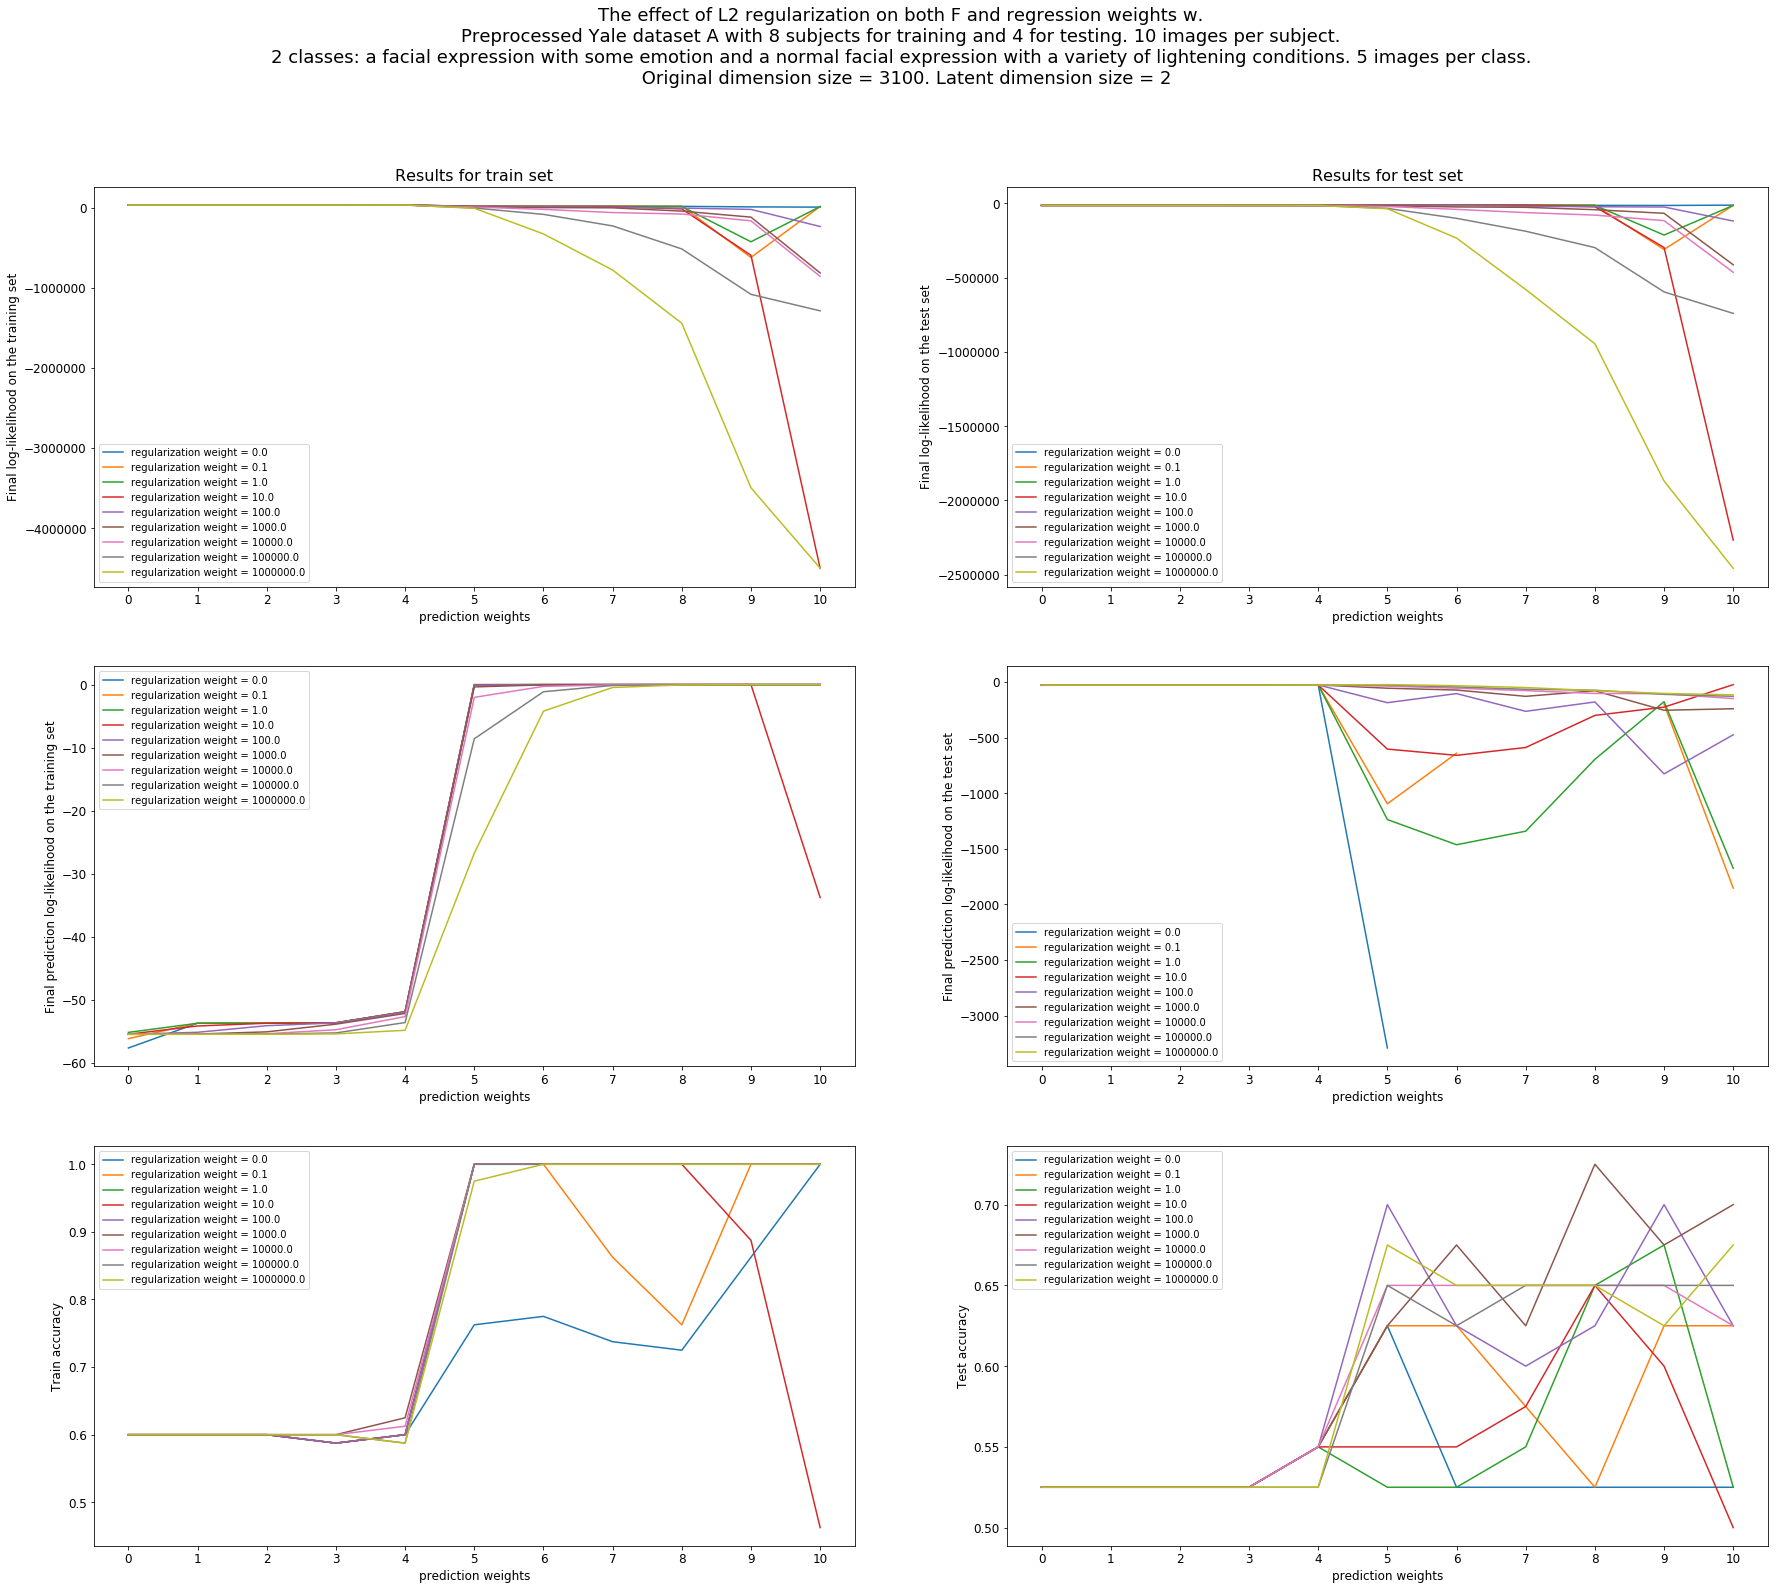

In [67]:
fig = plt.figure(figsize=(30,25))
fig.suptitle("The effect of L2 regularization on both F and regression weights w. \nPreprocessed Yale dataset A with 8 subjects for training and 4 for testing. 10 images per subject. \n2 classes: a facial expression with some emotion and a normal facial expression with a variety of lightening conditions. 5 images per class. \n Original dimension size = {}. Latent dimension size = {}".format(x_dim, latent_dim), fontsize=18)

plt.subplot(321)
plt.title("Results for train set", fontsize=16)
plt.ylabel("Final log-likelihood on the training set", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(x_ticks, fontsize=12)

#plt.xticks(np.arange(lambda_e_1,lambda_e_2, 0.1), fontsize=12)
plt.plot(x_ticks, ll_l_bfgs_b_train[0,:], label = "regularization weight = {}".format(reg_weights[0]))
plt.plot(x_ticks, ll_l_bfgs_b_train[1,:], label = "regularization weight = {}".format(reg_weights[1]))
plt.plot(x_ticks, ll_l_bfgs_b_train[2,:], label = "regularization weight = {}".format(reg_weights[2]))
plt.plot(x_ticks, ll_l_bfgs_b_train[3,:], label = "regularization weight = {}".format(reg_weights[3]))
plt.plot(x_ticks, ll_l_bfgs_b_train[4,:], label = "regularization weight = {}".format(reg_weights[4]))
plt.plot(x_ticks, ll_l_bfgs_b_train[5,:], label = "regularization weight = {}".format(reg_weights[5]))
plt.plot(x_ticks, ll_l_bfgs_b_train[6,:], label = "regularization weight = {}".format(reg_weights[6]))
plt.plot(x_ticks, ll_l_bfgs_b_train[7,:], label = "regularization weight = {}".format(reg_weights[7]))
plt.plot(x_ticks, ll_l_bfgs_b_train[8,:], label = "regularization weight = {}".format(reg_weights[8]))

plt.xlabel("prediction weights", fontsize=12)
plt.legend()

plt.subplot(322)
plt.title("Results for test set", fontsize=16)
plt.ylabel("Final log-likelihood on the test set", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(x_ticks, fontsize=12)

#plt.xticks(np.arange(lambda_e_1,lambda_e_2, 0.1), fontsize=12)
plt.plot(x_ticks, ll_l_bfgs_b_test[0,:], label = "regularization weight = {}".format(reg_weights[0]))
plt.plot(x_ticks, ll_l_bfgs_b_test[1,:], label = "regularization weight = {}".format(reg_weights[1]))
plt.plot(x_ticks, ll_l_bfgs_b_test[2,:], label = "regularization weight = {}".format(reg_weights[2]))
plt.plot(x_ticks, ll_l_bfgs_b_test[3,:], label = "regularization weight = {}".format(reg_weights[3]))
plt.plot(x_ticks, ll_l_bfgs_b_test[4,:], label = "regularization weight = {}".format(reg_weights[4]))
plt.plot(x_ticks, ll_l_bfgs_b_test[5,:], label = "regularization weight = {}".format(reg_weights[5]))
plt.plot(x_ticks, ll_l_bfgs_b_test[6,:], label = "regularization weight = {}".format(reg_weights[6]))
plt.plot(x_ticks, ll_l_bfgs_b_test[7,:], label = "regularization weight = {}".format(reg_weights[7]))
plt.plot(x_ticks, ll_l_bfgs_b_test[8,:], label = "regularization weight = {}".format(reg_weights[8]))

plt.xlabel("prediction weights", fontsize=12)
plt.legend()

plt.subplot(323)
plt.ylabel("Final prediction log-likelihood on the training set", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(x_ticks, fontsize=12)

#plt.xticks(np.arange(lambda_e_1,lambda_e_2, 0.1), fontsize=12)
plt.plot(x_ticks, pll_l_bfgs_b_train[0,:], label = "regularization weight = {}".format(reg_weights[0]))
plt.plot(x_ticks, pll_l_bfgs_b_train[1,:], label = "regularization weight = {}".format(reg_weights[1]))
plt.plot(x_ticks, pll_l_bfgs_b_train[2,:], label = "regularization weight = {}".format(reg_weights[2]))
plt.plot(x_ticks, pll_l_bfgs_b_train[3,:], label = "regularization weight = {}".format(reg_weights[3]))
plt.plot(x_ticks, pll_l_bfgs_b_train[4,:], label = "regularization weight = {}".format(reg_weights[4]))
plt.plot(x_ticks, pll_l_bfgs_b_train[5,:], label = "regularization weight = {}".format(reg_weights[5]))
plt.plot(x_ticks, pll_l_bfgs_b_train[6,:], label = "regularization weight = {}".format(reg_weights[6]))
plt.plot(x_ticks, pll_l_bfgs_b_train[7,:], label = "regularization weight = {}".format(reg_weights[7]))
plt.plot(x_ticks, pll_l_bfgs_b_train[8,:], label = "regularization weight = {}".format(reg_weights[8]))

plt.xlabel("prediction weights", fontsize=12)
plt.legend()

plt.subplot(324)
plt.ylabel("Final prediction log-likelihood on the test set", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(x_ticks, fontsize=12)

#plt.xticks(np.arange(lambda_e_1,lambda_e_2, 0.1), fontsize=12)
plt.plot(x_ticks, pll_l_bfgs_b_test[0,:], label = "regularization weight = {}".format(reg_weights[0]))
plt.plot(x_ticks, pll_l_bfgs_b_test[1,:], label = "regularization weight = {}".format(reg_weights[1]))
plt.plot(x_ticks, pll_l_bfgs_b_test[2,:], label = "regularization weight = {}".format(reg_weights[2]))
plt.plot(x_ticks, pll_l_bfgs_b_test[3,:], label = "regularization weight = {}".format(reg_weights[3]))
plt.plot(x_ticks, pll_l_bfgs_b_test[4,:], label = "regularization weight = {}".format(reg_weights[4]))
plt.plot(x_ticks, pll_l_bfgs_b_test[5,:], label = "regularization weight = {}".format(reg_weights[5]))
plt.plot(x_ticks, pll_l_bfgs_b_test[6,:], label = "regularization weight = {}".format(reg_weights[6]))
plt.plot(x_ticks, pll_l_bfgs_b_test[7,:], label = "regularization weight = {}".format(reg_weights[7]))
plt.plot(x_ticks, pll_l_bfgs_b_test[8,:], label = "regularization weight = {}".format(reg_weights[8]))
plt.xlabel("prediction weights", fontsize=12)
plt.legend()

plt.subplot(325)
plt.ylabel("Train accuracy", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(x_ticks, fontsize=12)
plt.plot(x_ticks, train_acc_l_bfgs_b[0,:], label = "regularization weight = {}".format(reg_weights[0]))
plt.plot(x_ticks, train_acc_l_bfgs_b[1,:], label = "regularization weight = {}".format(reg_weights[1]))
plt.plot(x_ticks, train_acc_l_bfgs_b[2,:], label = "regularization weight = {}".format(reg_weights[2]))
plt.plot(x_ticks, train_acc_l_bfgs_b[3,:], label = "regularization weight = {}".format(reg_weights[3]))
plt.plot(x_ticks, train_acc_l_bfgs_b[4,:], label = "regularization weight = {}".format(reg_weights[4]))
plt.plot(x_ticks, train_acc_l_bfgs_b[5,:], label = "regularization weight = {}".format(reg_weights[5]))
plt.plot(x_ticks, train_acc_l_bfgs_b[6,:], label = "regularization weight = {}".format(reg_weights[6]))
plt.plot(x_ticks, train_acc_l_bfgs_b[7,:], label = "regularization weight = {}".format(reg_weights[7]))
plt.plot(x_ticks, train_acc_l_bfgs_b[8,:], label = "regularization weight = {}".format(reg_weights[8]))
plt.xlabel("prediction weights", fontsize=12)
plt.legend()


plt.subplot(326)
plt.ylabel("Test accuracy", fontsize=12)
plt.yticks(fontsize=12)
plt.xticks(x_ticks, fontsize=12)

#plt.xticks(np.arange(lambda_e_1,lambda_e_2, 0.1), fontsize=12)
plt.plot(x_ticks, test_acc_l_bfgs_b[0,:], label = "regularization weight = {}".format(reg_weights[0]))
plt.plot(x_ticks, test_acc_l_bfgs_b[1,:], label = "regularization weight = {}".format(reg_weights[1]))
plt.plot(x_ticks, test_acc_l_bfgs_b[2,:], label = "regularization weight = {}".format(reg_weights[2]))
plt.plot(x_ticks, test_acc_l_bfgs_b[3,:], label = "regularization weight = {}".format(reg_weights[3]))
plt.plot(x_ticks, test_acc_l_bfgs_b[4,:], label = "regularization weight = {}".format(reg_weights[4]))
plt.plot(x_ticks, test_acc_l_bfgs_b[5,:], label = "regularization weight = {}".format(reg_weights[5]))
plt.plot(x_ticks, test_acc_l_bfgs_b[6,:], label = "regularization weight = {}".format(reg_weights[6]))
plt.plot(x_ticks, test_acc_l_bfgs_b[7,:], label = "regularization weight = {}".format(reg_weights[7]))
plt.plot(x_ticks, test_acc_l_bfgs_b[8,:], label = "regularization weight = {}".format(reg_weights[8]))
plt.xlabel("prediction weights", fontsize=12)
plt.legend()

plt.savefig("ppca_L2_yale_train_vs_test.png")
plt.show()

In [71]:
np.argmax(test_acc_l_bfgs_b)
regular_weight_id, pred_weight_id= np.unravel_index(np.argmax(test_acc_l_bfgs_b), (test_acc_l_bfgs_b.shape))
test_acc_l_bfgs_b[regular_weight_id, pred_weight_id]



0.725

In [95]:
f_best, bias_best, cov_noise_best, w_best = decode_parameters(params_opt_l_bfgs_b[regular_weight_id, pred_weight_id], x_dim, latent_dim, opt)
X_test_proj_best = transform(f_best, bias_best, cov_noise_best, X_test)
X_train_proj_best = transform(f_best, bias_best, cov_noise_best, X_train)
clf = LogisticRegression(solver='lbfgs').fit(X_train_proj_best, y_train)
y_test_pred = clf.predict(X_test_proj_best)


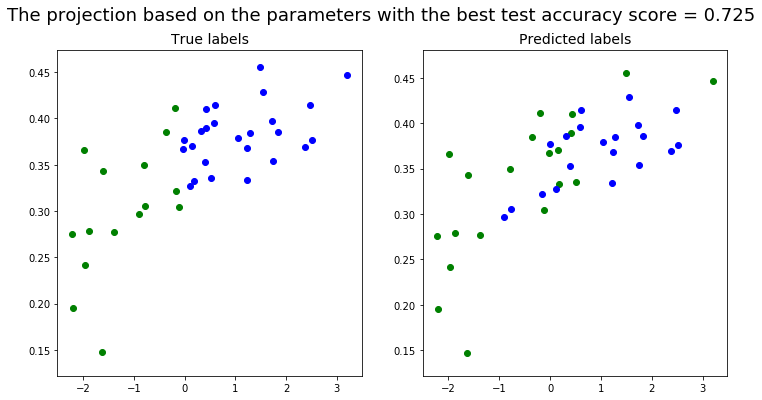

In [108]:
fig = plt.figure(figsize= (12,6))
fig.suptitle("The projection based on the parameters with the best test accuracy score = {}".format(test_acc_l_bfgs_b[regular_weight_id, pred_weight_id]), fontsize=18)
plt.subplot(121)
plt.title("True labels", fontsize=14)
X_class0 = X_proj_best[np.argwhere(y_test_pred==0)[:,0], :]
X_class1 = X_proj_best[np.argwhere(y_test_pred==1)[:,0], :]
plt.scatter(X_class0[:,0], X_class0[:,1], c='g')
plt.scatter(X_class1[:,0], X_class1[:,1], c='b')

plt.subplot(122)
plt.title("Predicted labels", fontsize=14)

X_class0 = X_proj_best[np.argwhere(y_test==0)[:,0], :]
X_class1 = X_proj_best[np.argwhere(y_test==1)[:,0], :]
plt.scatter(X_class0[:,0], X_class0[:,1], c='g')
plt.scatter(X_class1[:,0], X_class1[:,1], c='b')
plt.savefig("yale_best_projection_2d.png")

plt.show()


In [87]:
X_class0.shape

(20, 2)

In [ ]:
batch_size = 5
max_epoch = 100
step_size = 0.001

num_batches = int(np.ceil(x.shape[0]/batch_size))
num_iters = num_batches*max_epoch

def batch_indices(i):
    idx = i % num_batches
    return slice(idx * batch_size, (idx+1) * batch_size)

def get_grad_obj(params, x, y, latent_dim, lambda_e, opt, batch_idx):
    def opt_objective(params, batch_idx):
        idx = batch_indices(batch_idx)
        return objective_logit_fast(params, x[idx], y[idx], latent_dim, lambda_e, opt)
    return grad(opt_objective)

In [ ]:
lambda_e = 1000

print("     Epoch     |    Obj value     |    Train accuracy")
def print_perf(params, iter, gradient):
    if iter % num_batches == 0:
        obj_val = objective_logit_fast(params, X_train, y_train, latent_dim, lambda_e, opt)
        f, bias, cov_noise, w =  decode_parameters(params, x_dim, latent_dim, opt)
        x_train_transformed = transform(f, bias, cov_noise, X_train)
        clf_pc = LogisticRegression().fit(x_train_transformed, y_train)
        train_acc = clf_pc.score(x_train_transformed, y_train)
        print("{:15}|{:20}|{:20}".format(iter//num_batches, obj_val, train_acc))

params_opt_adam_logit = adam(get_grad_obj(init_params, X_train, y_train, latent_dim, lambda_e, opt, iter), init_params, step_size = step_size,  callback=print_perf, num_iters=num_iters)


In [ ]:
f, bias, cov_noise, w =  decode_parameters(params_opt_adam_logit, x_dim, latent_dim, opt)
x_train_transformed = transform(f, bias, cov_noise, X_train)
x_test_transformed = transform(f, bias, cov_noise, X_test)

clf_pc = LogisticRegression().fit(x_train_transformed, y_train)
test_acc = clf_pc.score(x_test_transformed, y_test)
print test_acc

In [ ]:
grad_objective_logit = grad(objective_logit, argnum = 0)
grad_objective_logit_fast = grad(objective_logit_fast, argnum = 0)
#%lprun -f objective_logit_fast objective_logit_fast(init_params, x, y, latent_dim, 10, opt)

#%timeit grad_objective_logit_fast(init_params, x, y, latent_dim, 10, opt)
#%timeit grad_objective_logit(init_params, x, y, latent_dim, 10, opt)
#%timeit grad_objective_logit(init_params, x, y, latent_dim, 10, opt)